Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for notMNIST_large. This may take a while. Please wait.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
Extracting data for notMNIST_small. This may take a while. Please wait.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


In [11]:
train_folders

['notMNIST_large/A',
 'notMNIST_large/B',
 'notMNIST_large/C',
 'notMNIST_large/D',
 'notMNIST_large/E',
 'notMNIST_large/F',
 'notMNIST_large/G',
 'notMNIST_large/H',
 'notMNIST_large/I',
 'notMNIST_large/J']

In [5]:
ls notMNIST_large/

A/ B/ C/ D/ E/ F/ G/ H/ I/ J/


In [12]:
pwd

u'/Users/zangsir/repo/deepLearningCode/notMNIST_small/A'

In [13]:
cd ../..

/Users/zangsir/repo/deepLearningCode


In [14]:
ls

1_notmnist.ipynb                 notMNIST_large.tar.gz
README.md                        notMNIST_small/
deep-learning-course-shuo.ipynb  notMNIST_small.tar.gz
notMNIST_large/


### to see some images, look at it in deep-learning-course.ipynb

---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [15]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling notMNIST_large/A.pickle.
notMNIST_large/A
Could not read: notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.443121
Pickling notMNIST_large/B.pickle.
notMNIST_large/B
Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.00756303
Standard deviation: 0.454491
Pickling notMNIST_large/C.pic

In [17]:
ls notMNIST_small/

A/        B.pickle  D/        E.pickle  G/        H.pickle  J/
A.pickle  C/        D.pickle  F/        G.pickle  I/        J.pickle
B/        C.pickle  E/        F.pickle  H/        I.pickle  save.p


---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [18]:
sample=pickle.load( open( "notMNIST_small/A.pickle", "rb" ) )

In [19]:
type(sample)

numpy.ndarray

In [24]:
sample.shape

(1872, 28, 28)

In [26]:
sample[0][0]

array([-0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
       -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
       -0.45294118, -0.45686275, -0.49607843, -0.5       , -0.46470588,
       -0.48039216, -0.5       , -0.49607843, -0.5       , -0.5       ,
       -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
       -0.5       , -0.5       , -0.5       ], dtype=float32)

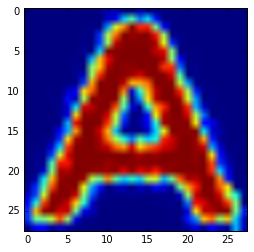

In [29]:
plt.imshow(sample[0])

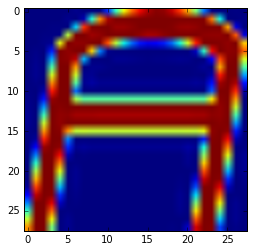

In [32]:
plt.imshow(sample[300])

In [69]:
sample[2].shape

(28, 28)

In [72]:
In [2]: import matplotlib.pyplot as plt
In [3]: import matplotlib.image as mpimg
In [4]: import numpy as np
img=mpimg.imread('stinkbug.png')

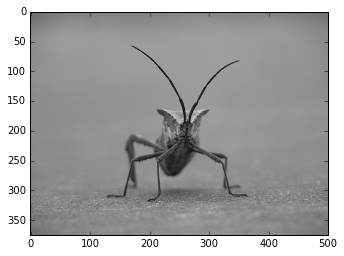

In [73]:
imgplot = plt.imshow(img)

In [76]:
img.shape

(375, 500, 3)

In [77]:
In [7]: lum_img = img[:,:,0]


In [79]:
lum_img.shape

(375, 500)

In [81]:
img[1].shape

(500, 3)

In [71]:
ls

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [61]:
#verifying balanced classes....
folder='notMNIST_large/'
folder='notMNIST_small/'
pickle_files=os.listdir(folder)
for file in pickle_files:
    #print(file)
    if file.endswith('pickle'):
        #print ('pickle')
        sample=pickle.load( open( folder+file, "rb" ) )

        print(sample.shape)

(1872, 28, 28)
(1873, 28, 28)
(1873, 28, 28)
(1873, 28, 28)
(1873, 28, 28)
(1872, 28, 28)
(1872, 28, 28)
(1872, 28, 28)
(1872, 28, 28)
(1872, 28, 28)


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [84]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    #this is basically for each pickle file, pick and merge them into train, val, test sets
    
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                    
                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
    
    return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [113]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [100]:
permutation = np.random.permutation(train_labels[:100].shape[0])
#from these (below) you can understand the randomization: let's say we take 100 samples from
#training set and shuffle them, so we basically have 100 28*28 images, and given the permutation
#shown below, such as [89,44...], we take the 89th image and put it in the first position, etc. 
#and we also shuffle the labels of course

In [101]:
permutation

array([89, 44,  9, 98, 55, 75, 88,  0, 45, 67, 64, 77, 43, 41, 46, 19, 71,
       56, 13, 58, 33, 72, 80, 48, 85, 24, 16, 20,  4, 18, 94, 70, 61, 60,
       25, 66, 99, 52, 10, 92, 29, 27, 83, 26, 90, 30, 31, 87, 54,  1, 22,
       73, 14,  5, 36, 68, 49, 53, 57, 39, 95, 93, 28, 32,  7, 21, 91, 51,
        6, 78, 17, 97, 38, 40, 50, 23, 63, 96,  8, 65, 34, 12, 47,  3, 37,
       15, 82,  2, 69, 84, 62, 74, 81, 35, 86, 76, 79, 11, 42, 59])

In [111]:
dfh[89]

array([[ 0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
         0.36274511, -0.11568628, -0.5       ],
       [ 0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.48823529,
         0.48823529,  0.48823529,  0.48823529,  0.48823529,  0.48823529,
         0.48431373,  0.48431373,  0.48431373,  0.48431373,  0.48431373,
         0.48431373,  0.48431373,  0.48431373,  0.48431373,  0.48431373,
         0.31960785, -0.2254902 , -0.5       ],
       [ 0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ,  0.5   

In [99]:
dfh=train_dataset[:100]
shuffled_dataset = dfh[permutation,:,:]


In [112]:
shuffled_dataset[0]# the shuffled first element of the array is the same as the original 89th image, shown above.

array([[ 0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
         0.36274511, -0.11568628, -0.5       ],
       [ 0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.48823529,
         0.48823529,  0.48823529,  0.48823529,  0.48823529,  0.48823529,
         0.48431373,  0.48431373,  0.48431373,  0.48431373,  0.48431373,
         0.48431373,  0.48431373,  0.48431373,  0.48431373,  0.48431373,
         0.31960785, -0.2254902 , -0.5       ],
       [ 0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ,  0.5   

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [115]:
#train_dataset, train_labels = randomize(train_dataset, train_labels)
#test_dataset, test_labels = randomize(test_dataset, test_labels)
#valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

valid_dataset.shape

(10000, 28, 28)

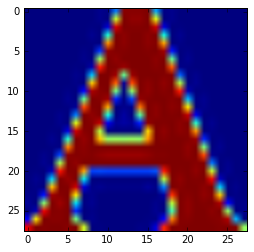

In [118]:
plt.imshow(valid_dataset[200])

In [119]:
valid_labels[200]

0

Finally, let's save the data for later reuse:

In [120]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [121]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [124]:
train_dataset.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

In [150]:
train_dataset.flags.writeable=False
test_dataset.flags.writeable=False
dup_table={}
num_dup=0
for idx,img in enumerate(train_dataset):
    h = hash(img.data)# here the idea is that the duplicated img.data array will hash to the same bucket. 
    if h in dup_table and (train_dataset[dup_table[h]].data == img.data):#this means the hash function value 
        #is the same as an existing hashed entry, and also their data are the same, double sure. 
        #print ('Duplicate image: %d matches %d' % (idx, dup_table[h]))
        num_dup+=1
    dup_table[h] = idx
print(num_dup)
dup_test=0
for idx,img in enumerate(test_dataset):
    h = hash(img.data)
    #notice that there are 12614 duplicates, so the size of the dup_table is 200000-12614, and these are all the 
    #unique images found in the training set, you can compare test set against this set. 
    if h in dup_table and (train_dataset[dup_table[h]].data == img.data):
        #print('Test image %d is in the training set' % idx)
        dup_test+=1
print(dup_test)

#more methods at https://discussions.udacity.com/t/assignment-1-problem-5/45657/10

In [148]:
len(train_labels)

200000

In [151]:
len(dup_table)+num_dup


200000

In [127]:
for idx,img in enumerate(train_dataset[:2]):
    print(idx,img)

In [129]:
img.data

<read-write buffer for 0x11003a8f0, size 3136, offset 0 at 0x111bf3ef0>

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

## Using a one-versus-other logit classifier with example from sklearn

In [163]:
#example from sklearn, and initialize classifier
print(__doc__)

from sklearn import datasets, neighbors, linear_model

digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

n_samples = len(X_digits)

X_train = X_digits[:.9 * n_samples]
y_train = y_digits[:.9 * n_samples]
X_test = X_digits[.9 * n_samples:]
y_test = y_digits[.9 * n_samples:]

knn = neighbors.KNeighborsClassifier()
logistic = linear_model.LogisticRegression()

print('KNN score: %f' % knn.fit(X_train, y_train).score(X_test, y_test))
print('LogisticRegression score: %f'
      % logistic.fit(X_train, y_train).score(X_test, y_test))

In [171]:
#sklearn linear classifier expects 2d array, so this just kind of expand the 2d array for each
#sample into 1d, and keep the 200000 samples
nsamples, nx, ny = train_dataset.shape
d2_train_dataset = train_dataset.reshape((nsamples,nx*ny))

nsamples, nx, ny = valid_dataset.shape
d2_valid_dataset = valid_dataset.reshape((nsamples,nx*ny))

nsamples, nx, ny = test_dataset.shape
d2_test_dataset = test_dataset.reshape((nsamples,nx*ny))

In [167]:
d2_train_dataset.shape

(200000, 784)

In [161]:
train_labels.shape

(200000,)

In [173]:
d2_train_dataset.shape

(200000, 784)

In [175]:
d2_test_dataset.shape

(10000, 784)

In [179]:
#vary training size 100, 1000, 5000, etc. 
print('LogisticRegression score: %f'
      % logistic.fit(d2_train_dataset[:5000], train_labels[:5000]).score(d2_test_dataset, 
                                                                         test_labels))

## using a multinomial (softmax) logistic classifier

In [180]:
clf=LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42, verbose=1, 
                       max_iter=1000 )

In [183]:
print('LogisticRegression score: %f'
      % clf.fit(d2_train_dataset[:5000], train_labels[:5000]).score(d2_test_dataset, 
                                                                         test_labels))

# Conclusion

Here we see that the accuracy is around 85% no matter the classifier. 

In [ ]:
#cross validation
#https://www.youtube.com/watch?v=o7zzaKd0Lkk